In [95]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
%matplotlib inline

batch_size=16
learning_rate = 0.002
num_epoch = 60


In [77]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor()
])
test_transforms = transforms.Compose([
                                       transforms.ToTensor()
])
cifar_train = dset.CIFAR10('CIFAR10/',train=True,transform=train_transforms,target_transform=None,download=True)
cifar_test = dset.CIFAR10('CIFAR10/',train=False,transform=test_transforms,target_transform=None,download=True)

Files already downloaded and verified
Files already downloaded and verified


cifar_train 길이:  50000
cifar_test 길이:  10000


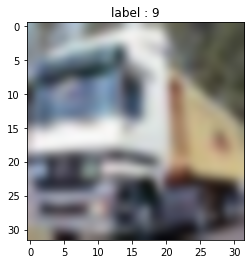

In [5]:
print('cifar_train 길이: ',len(cifar_train))
print('cifar_test 길이: ',len(cifar_test))

image,label = cifar_train.__getitem__(1)

image = image.permute(1,2,0)
plt.title('label : %d'%label)
plt.imshow(image,interpolation='bicubic')
plt.show()

In [19]:
def ComputeAccr(dloader,imodel):
  correct = 0
  total = 0

  for j,(imgs,labels) in enumerate(dloader):
    imgs = Variable(imgs,requires_grad=False).cuda()
    labels = Variable(labels).cuda()

    output = imodel(imgs)
    _, output_index = torch.max(output,1)

    total +=labels.shape[0]
    correct +=(labels==output_index).sum().float()

  print('Accuracy of Test Data: %f'%(100*correct/total))

In [83]:
train_loader = DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [98]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(3,16,3,padding=1),
        nn.ReLU(),
        # nn.Dropout2d(0.2),
        # nn.BatchNorm2d(16),

        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        # nn.Dropout2d(0.2),
        # nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),

        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        # nn.Dropout2d(0.2),
        # nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)
    )
    self.fc_layer = nn.Sequential(
        nn.Linear(64*8*8,100),
        nn.ReLU(),
        # nn.Dropout2d(0.2),
        # nn.BatchNorm1d(100),
        nn.Linear(100,10)
    )
    
    # for m in self.modules():
    #   if isinstance(m,nn.Conv2d):
    #     init.kaiming_normal_(m.weight.data)
    #     m.bias.data.fill_(0)
    #   if isinstance(m,nn.Linear):
    #     init.kaiming_normal_(m.weight.data)
    #     m.bias.data.fill_(0)

  def forward(self,x):
    out = self.layer(x)
    out = out.view(out.shape[0],-1)
    out = self.fc_layer(out)

    return out

model = CNN().cuda()

In [99]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.2)

for i in range(num_epoch):
  for j,(imgs,labels) in enumerate(train_loader):
    imgs = Variable(imgs, requires_grad=True).cuda()
    labels = Variable(labels).cuda()

    optimizer.zero_grad()
    out = model(imgs)
    loss = loss_func(out,labels)
    loss.backward()

    optimizer.step()

    if j%1000==0:
      print(j,loss)
  scheduler.step()

0 tensor(2.3048, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(2.3108, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(2.2937, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(2.2917, device='cuda:0', grad_fn=<NllLossBackward>)
0 tensor(2.2937, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(2.3094, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(1.9137, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(1.8901, device='cuda:0', grad_fn=<NllLossBackward>)
0 tensor(1.6751, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(1.7833, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(2.1759, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(1.7598, device='cuda:0', grad_fn=<NllLossBackward>)
0 tensor(2.0413, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(1.8387, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(1.4767, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(1.6113, device='cuda:0', grad_fn=<NllLos

# **(0) Naive Test**

In [20]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 10.650000


# **(1) Drop out**

In [24]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 14.929999


# **(2) Data augmentation**

In [38]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 15.080000


# **(3) Wieht initialization**

In [46]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 45.849998


# **(4) Data Normalization**

In [66]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 26.250000


# **(5) Batch normalization**

In [76]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 61.570000


# **(6) Adam Optimizer**

In [81]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 56.989998


# **(7) learning rate decay**

In [100]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 65.970001


In [93]:
netname = './nets/my_net01.pkl'
torch.save(model,netname)

In [94]:
model = torch.load(netname)

ComputeAccr(test_loader,model)

Accuracy of Test Data: 18.660000
